In this notebook, we reference the baseline_test_predictions.csv (containing probabilities and truth values) to perform the following steps: 
- Apply thresholding based on F1 Score to determine correct classes (0 or 1).
- Compute performance metrics: Accuracy, Precision, Recall, F1 Score.
- Calculate False Positive Rate (FPR) for the “No Finding” label.
- Plot the FPR for the baseline models
- Debiasing Analysis
- Analyze potential biases in model predictions based on demographic attributes.
- Apply debiasing techniques (once determined)
- Recalculate performance metrics.
- Evaluation Metrics
- FPR after debiasing
- Recalculate and plot the FPR after debiasing.
- Compare FPR before and after debiasing to see if the gap is reduced.
- Summary & Interpretations:
    - Compare baseline vs. debiased model results.
    - Highlight key insights on bias mitigation.

## Initial setup

### Library Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading

In [ ]:
df = pd.read_csv("BaseLine/baseline_test_predictions.csv")
df.head()

,subject_id,study_id,Enlarged Cardiomediastinum_ground_truth,Cardiomegaly_ground_truth,Lung Opacity_ground_truth,Lung Lesion_ground_truth,Edema_ground_truth,Consolidation_ground_truth,Pneumonia_ground_truth,Atelectasis_ground_truth,...,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10001176,tensor(53186264),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
1,10001176,tensor(54684191),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
2,10001176,tensor(54684191),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
3,10001217,tensor(52067803),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,DIRECT EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,?,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0
4,10001217,tensor(58913004),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,DIRECT EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,?,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0


In [ ]:
# list of all column labels from dataset
labels = ["Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"]

def get_label_data(df, label):
    y_true = df[f"{label}_ground_truth"]                            # adding "groud_truth" suffix
    y_prob = df[f"{label}_probability"]                             # adding "probability" suffix
    return y_true, y_prob

def find_best_threshold( y_true, y_prob):
    thresholds = np.linspace(0, 1, 100)                            # test 100 thresholds between 0.0. and 1.0
    best_threshold = 0
    best_f1 = 0
    f1_scores = []

    for threshold in thresholds:                                    # threshold used to get the predictions later ( if anything >= threshold, prediction = 1, else 0)
        y_pred = []
        for prob in y_prob:
            # convert probabilities to binary predictions
            if prob >= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        # f1 score for current threshold
        f1 = f1_score(y_true, y_pred, zero_division = 0)
        f1_scores.append(f1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# process all labels to find the best one for each
def process_all_labels(df, labels):
    results = {}
    for label in labels:
        print(f"Processing Label: {label}")
        y_true, y_prob = get_label_data(df, label)                                              # get ground truth and predicted probabilites for the label
        
        print("Truth Sample:", y_true.head().tolist())
        print("Prob Sampe: ", y_prob.head().tolist())

        best_threshold, best_f1 = find_best_threshold(y_true, y_prob)                           # find best threshold and f1 score
        results[label] = {"best_threshold": best_threshold, "best_f1": best_f1}
    
        print("\n----------")
        print(f"Best Threshold For Label '{label}' Based On F1 Score: {best_threshold}")
        print(f"Best F1 Score Overall: {best_f1}")

    return results 

results = process_all_labels(df, labels)

Processing Label: Enlarged Cardiomediastinum
Truth Sample: [0.0, 0.0, 0.0, 0.0, 0.0]
Prob Sampe:  [0.011228524, 0.03717068, 0.049578283, 0.013247089, 0.01966936]

----------
Best Threshold For Label 'Enlarged Cardiomediastinum' Based On F1 Score: 0.0
Best F1 Score Overall: 0.06809234073013601
Processing Label: Cardiomegaly
Truth Sample: [0.0, 0.0, 0.0, 0.0, 1.0]
Prob Sampe:  [0.107249245, 0.39783964, 0.48069987, 0.03568032, 0.10560523]

----------
Best Threshold For Label 'Cardiomegaly' Based On F1 Score: 0.30303030303030304
Best F1 Score Overall: 0.5186583168911384
Processing Label: Lung Opacity
Truth Sample: [1.0, 0.0, 0.0, 0.0, 0.0]
Prob Sampe:  [0.0688593, 0.2894648, 0.28179815, 0.06424006, 0.054042153]

----------
Best Threshold For Label 'Lung Opacity' Based On F1 Score: 0.20202020202020202
Best F1 Score Overall: 0.5061944519256666
Processing Label: Lung Lesion
Truth Sample: [0.0, 0.0, 0.0, 0.0, 0.0]
Prob Sampe:  [0.007917892, 0.018727511, 0.027182437, 0.030550435, 0.0076487325]


### Generate Predictions and Evaluate

Computes standard classification metrics based on given/passed in threshold

In [ ]:
def evaluate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)                                      # convert probabilites into binary 
    
    return{"Accuracy: ": accuracy_score(y_true, y_pred), "Precision: ": precision_score(y_true, y_pred, zero_division = 0), "Recall: ": recall_score(y_true, y_pred, zero_division = 0), "F1 Score: ": f1_score(y_true, y_pred, zero_division = 0)}


y_true, y_prob = get_label_data(df, "No Finding")                                   # exract ground truth and probability values for 'No Finding' label
best_threshold, best_f1 = find_best_threshold(y_true, y_prob)                       # find best threshold for it
metrics = evaluate_metrics(y_true, y_prob, best_threshold)                          # evaluate metrics at the best threshold
y_pred = (y_prob >= best_threshold).astype(int)                                     # generate binary predictions - used later for FPR and plotting

print("\n---------- METRICS -------------")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value}")
print("--------------------------------")

False Positive Rate (FPR) for 'No Finding' Label:  0.1947884940778342

---------- METRICS -------------
Accuracy: : 0.80056505025242
Precision: : 0.6518267602225986
Recall: : 0.7904929577464789
F1 score: : 0.7144940989258719
--------------------------------


### Calculate FPR for 'No Finding' Label

Calculate FPR for previously defined label

In [84]:
def calculate_fpr(y_true, y_pred):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_pred).ravel()
    if(false_positive + true_negative) > 0:
        false_positive_rate = false_positive / (false_positive + true_negative)  
    else: false_positive_rate = 0
    
    print(f"False Positive Rate (FPR) for 'No Finding' Label: ", false_positive_rate)
    return false_positive_rate

fpr = calculate_fpr(y_true, y_pred)

False Positive Rate (FPR) for 'No Finding' Label:  0.1947884940778342


### Plotting FPR Across Demographics


--- Group: F ---
Total in group: 9678
True class distribution: {0.0: 6329, 1.0: 3349}
Predicted class distribution: {0: 5549, 1: 4129}
Best threshold for 'No Finding': 0.303
False Positive Rate (FPR) for 'No Finding' Label:  0.21488386790962238
Stored FPR for gorup F:0.21488386790962238

--- Group: M ---
Total in group: 11913
True class distribution: {0.0: 8446, 1.0: 3467}
Predicted class distribution: {0: 7776, 1: 4137}
Best threshold for 'No Finding': 0.303
False Positive Rate (FPR) for 'No Finding' Label:  0.17973004972768175
Stored FPR for gorup M:0.17973004972768175
Returned FPRs: {'F': 0.21488386790962238, 'M': 0.17973004972768175}

Filtered:  <class 'dict'> {'F': 0.21488386790962238, 'M': 0.17973004972768175}
Raw FPRs: {'F': 0.21488386790962238, 'M': 0.17973004972768175}
Filtered: {'F': 0.21488386790962238, 'M': 0.17973004972768175}


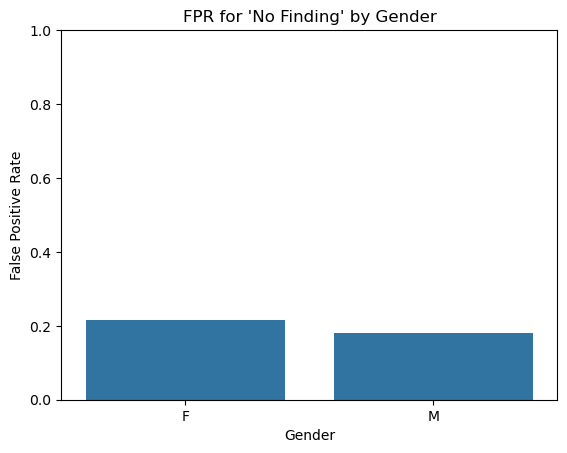

In [ ]:
def calculate_fpr_by_grouped(df, label, group_column):
    fprs = {}
    y_true, y_prob = get_label_data(df, label)                                                  # extract ground truth and predictions for the label 
    best_threshold, _ = find_best_threshold(y_true, y_prob)                                     # find best threshold for converting probabilities to binary 
    y_pred = (y_prob >= best_threshold).astype(int)

    # temporary df for predictions and ground truth
    temp_df = df.copy()
    temp_df["true_class"] = y_true
    temp_df["pred_class"] = y_pred

    for group in temp_df[group_column].dropna().unique():                                       # loop through each unique group value e.g M and F in Gender
        group_subset = temp_df[temp_df[group_column] == group]
        
        print(f"\n--- Group: {group} ---")
        print("Total in group:", len(group_subset))
        print("True class distribution:", group_subset["true_class"].value_counts().to_dict())
        print("Predicted class distribution:", group_subset["pred_class"].value_counts().to_dict())
        print(f"Best threshold for '{label}': {best_threshold:.3f}")

        if group_subset["pred_class"].nunique() < 2 or group_subset["true_class"].nunique() < 2:        # check if there is enough varying data 
            print(f"Skipping group {group} since theres not enough varying data")
            fpr[group] = None   
        else:
            fpr = calculate_fpr(group_subset["true_class"], group_subset["pred_class"])                 # calculate FPR 
            fprs[group]= fpr
            print(f"Stored FPR for gorup {group}:{fprs[group]}")
    print(f"Returned FPRs:", fprs)
    return fprs

# specify label and group column
label = "No Finding"
group_column = "gender"

# calls the group-based FPR 
fprs_by_gender = calculate_fpr_by_grouped(df, label, group_column)

# filter any Noneo or NaN values
filtered_fprs = {}
for key, value in fprs_by_gender.items():
    if value is not None and not np.isnan(value):
        filtered_fprs[key] = value

print("\nFiltered: ", type(filtered_fprs), filtered_fprs)
print("Raw FPRs:", fprs_by_gender)
print("Filtered:", filtered_fprs)

# --- Plotting ---
# only if there are valid entries
if filtered_fprs:
    sns.barplot(x = list(filtered_fprs.keys()), y = list(filtered_fprs.values()))
    plt.title(f"FPR for '{label}' by {group_column.capitalize()}")
    plt.ylabel("False Positive Rate")
    plt.xlabel(group_column.capitalize())
    # plt.legend()
    plt.ylim(0, 1)
    plt.show()
else:
    print("No valid FPR To Plot!")

In [ ]:
print(fprs_by_gender)

{'F': 0.21488386790962238, 'M': 0.17973004972768175}


In [87]:
print(df["No Finding_ground_truth"].value_counts())
print(df["No Finding_probability"].describe())

No Finding_ground_truth
0.0    14775
1.0     6816
Name: count, dtype: int64
count    21591.000000
mean         0.303539
std          0.271549
min          0.011883
25%          0.079605
50%          0.179034
75%          0.503628
max          0.949378
Name: No Finding_probability, dtype: float64
